In [168]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import norm

# Default plotting style
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

In [249]:
def load_stock_data(name, start_date, end_date):
    return quandl.get('WIKI/' + name, start_date=start_date, end_date=end_date)['Adj. Close']

In [495]:
data = load_stock_data("AMZN", "2006-01-01", "2018-01-01")

In [496]:
df = pd.DataFrame([data]).T

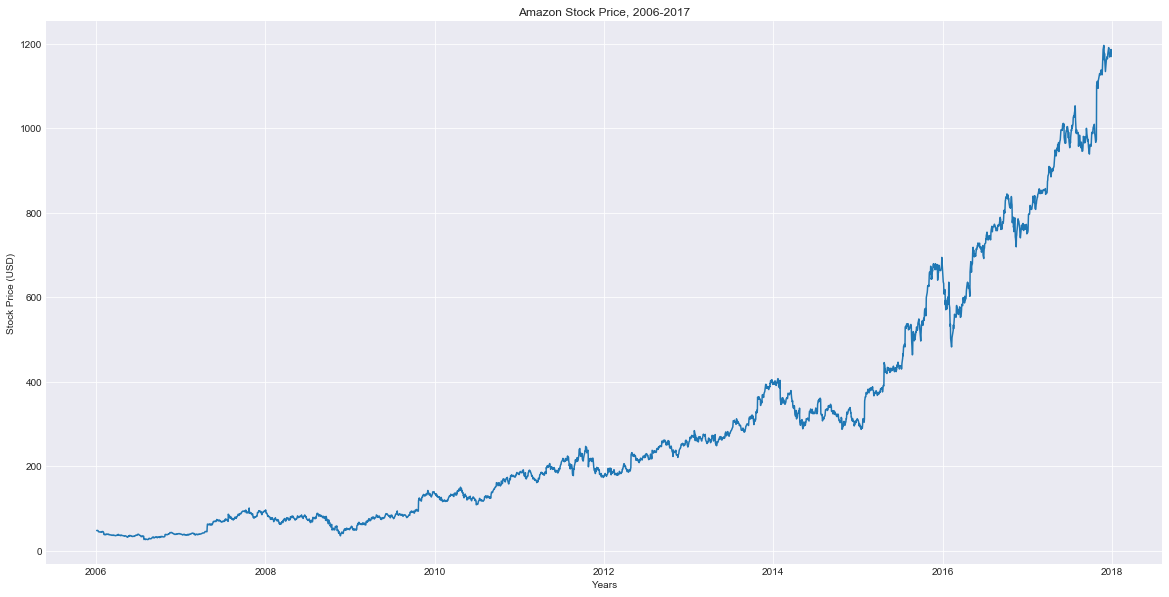

In [623]:
plt.figure(figsize=(20, 10))
plt.plot(df)
plt.ylabel("Stock Price (USD)")
plt.xlabel("Years")
plt.title("Amazon Stock Price, 2006-2017");

In [498]:
df.head()

,Adj. Close
Date,
2006-01-03,47.58
2006-01-04,47.25
2006-01-05,47.65
2006-01-06,47.87
2006-01-09,47.08


In [499]:
df.tail()

,Adj. Close
Date,
2017-12-22,1168.36
2017-12-26,1176.76
2017-12-27,1182.26
2017-12-28,1186.10
2017-12-29,1169.47


In [500]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3018 entries, 2006-01-03 to 2017-12-29
Data columns (total 1 columns):
Adj. Close    3018 non-null float64
dtypes: float64(1)
memory usage: 127.2 KB


In [501]:
df.describe()

,Adj. Close
count,3018.000000
mean,298.814908
std,279.345424
min,26.070000
25%,81.085000
50%,204.850000
75%,375.092500
max,1195.830000


## Core variables 

In [502]:
log_returns = np.log(1 + data.pct_change())

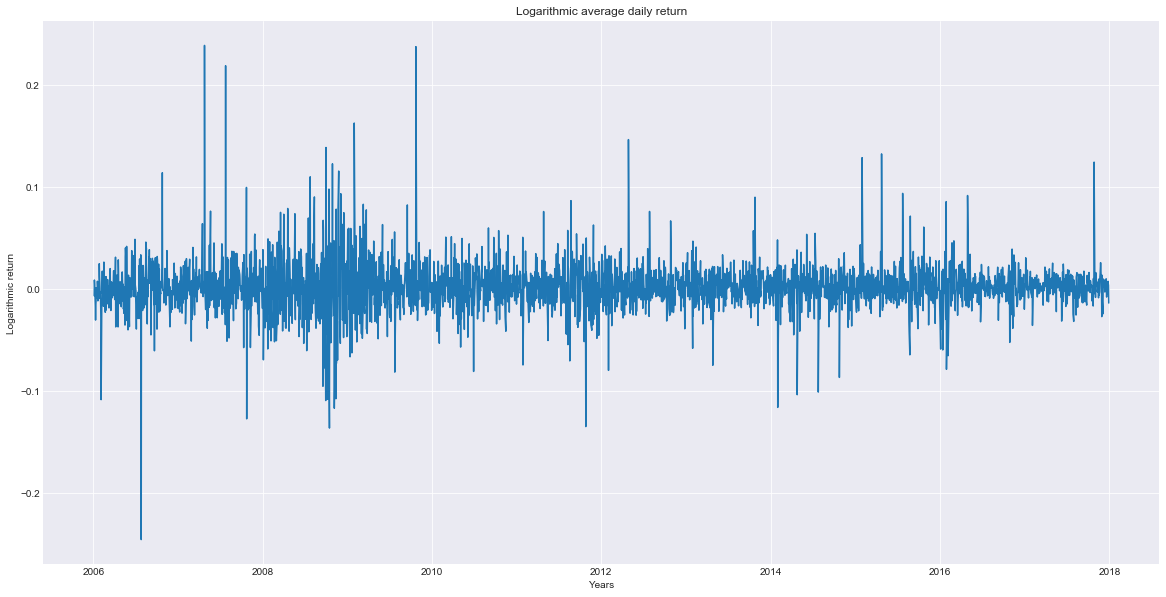

In [622]:
plt.figure(figsize=(20, 10))
plt.plot(log_returns);
plt.ylabel("Logarithmic return")
plt.xlabel("Years")
plt.title("Logarithmic average daily return");

#### Mean

In [504]:
u = log_returns.mean()

In [505]:
u

0.0010612838676938585

#### Variance

In [506]:
var = log_returns.var()

In [507]:
var

0.0006202206619998344

#### Standard deviation

In [508]:
std = log_returns.std()

In [509]:
std

0.024904229801377804

#### Drift 

In [510]:
drift = u - (0.5 * var)

In [511]:
drift

0.0007511735366939413

# Prediction

In [590]:
days = 365
itr = 10000

In [591]:
Z = norm.ppf(np.random.rand(days, itr))

In [592]:
Z

array([[ 0.49769286,  0.0286466 , -1.4522733 , ...,  0.9267104 ,
         0.07443577,  0.13003515],
       [-0.38667669, -0.03925958, -0.79136333, ...,  0.50917194,
        -0.9749992 ,  2.04813944],
       [ 1.59625995, -0.09248915, -0.62615629, ..., -0.28750268,
         1.40533922,  0.89617069],
       ...,
       [ 0.31954244, -1.35926195,  0.14347715, ...,  2.27835331,
         0.70083208, -0.92572617],
       [ 0.69694002,  0.25682759, -0.3238854 , ...,  0.24284472,
        -0.97459491, -1.63600295],
       [-0.65842357, -2.07543878,  0.71215708, ...,  0.30914179,
        -0.18404171,  0.4102647 ]])

In [593]:
daily_expected_return = np.exp(drift + std * Z)

In [594]:
daily_expected_return

array([[1.01323262, 1.00146567, 0.96520325, ..., 1.02411639, 1.00260833,
        1.00399757],
       [0.99116059, 0.99977347, 0.98122144, ..., 1.01352232, 0.97674425,
        1.05312139],
       [1.04133631, 0.99844901, 0.98526684, ..., 0.99361163, 1.03639678,
        1.02333778],
       ...,
       [1.00874717, 0.96744162, 1.00433372, ..., 1.05917659, 1.01837158,
        0.97794356],
       [1.01827287, 1.00717287, 0.99271175, ..., 1.0068222 , 0.97675409,
        0.96079691],
       [0.98447541, 0.95033946, 1.01865884, ..., 1.00848591, 0.99617509,
        1.01102887]])

In [595]:
last_closing_price = data.iloc[-1]

In [596]:
last_closing_price

1169.47

In [597]:
predicted_prices = np.zeros_like(daily_expected_return)

In [598]:
predicted_prices[0] = last_closing_price

In [599]:
for day in range(1, days):
    predicted_prices[day] = predicted_prices[day-1] * daily_expected_return[day]

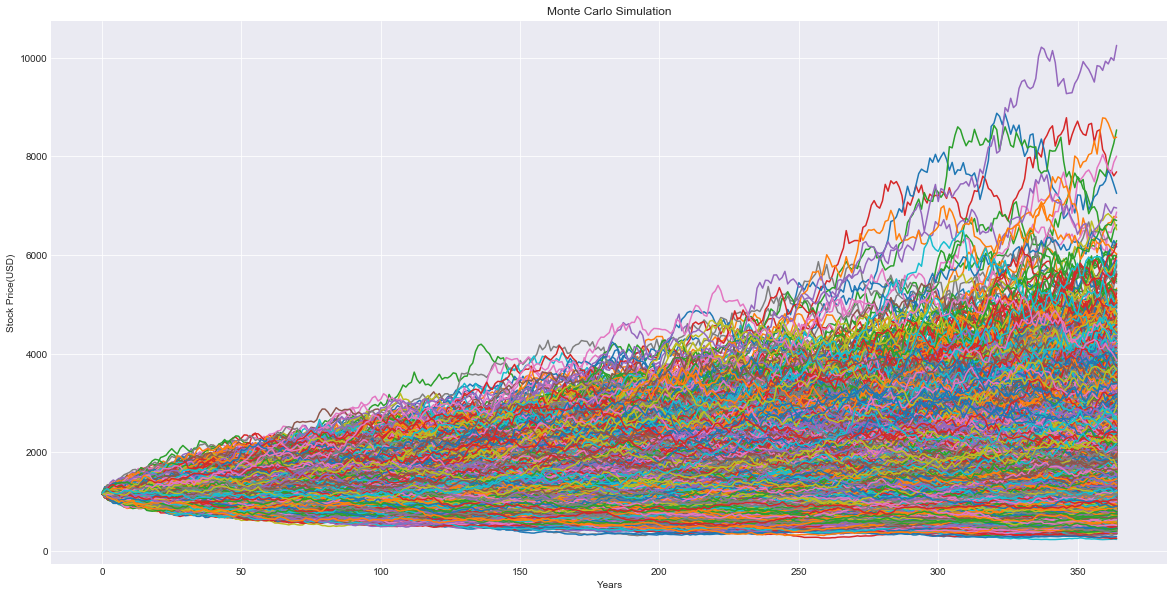

In [624]:
plt.figure(figsize=(20, 10))
plt.plot(predicted_prices)
plt.ylabel("Stock Price(USD)")
plt.xlabel("Years")
plt.title("Monte Carlo Simulation");

# Statistics

In [625]:
def run_stats(predicted_prices):
    median_expected_price = np.median(predicted_prices)
    average_expected_price = np.average(predicted_prices)
    max_expected_price = np.amax(predicted_prices)
    min_expected_price = np.amin(predicted_prices)
    
    print("Median: ", median_expected_price)
    print("Average: ",  average_expected_price)
    print("Max: ", max_expected_price)
    print("Min: ", min_expected_price)

In [626]:
run_stats(predicted_prices[364])

Median:  1544.9186280339657
Average:  1717.4938581454905
Max:  10250.358748643852
Min:  233.65928525554594


### Remove Outliers

In [627]:
# How many samples to keep

# std_level: 1 = 68,2 %
# std_level: 2 = 95,4 %
# std_level: 3 = 99,6 %

def remove_outliers(predicted_prices, std_level=1):
    u = np.mean(predicted_prices)
    std = np.std(predicted_prices)
    predicted_prices_lower_bound = [x for x in predicted_prices if (x > u - std_level * std)]
    predicted_prices_no_outliers = [x for x in predicted_prices_lower_bound if (x < u + std_level * std)]
    print("Removed %d outliers" % (len(predicted_prices) - len(predicted_prices_no_outliers)))
    return predicted_prices_no_outliers

In [628]:
predicted_prices_no_outliers_std_1 = remove_outliers(predicted_prices[364], std_level=1)
predicted_prices_no_outliers_std_2 = remove_outliers(predicted_prices[364], std_level=2)
predicted_prices_no_outliers_std_3 = remove_outliers(predicted_prices[364], std_level=3)

Removed 2507 outliers
Removed 427 outliers
Removed 144 outliers


In [629]:
run_stats(predicted_prices_no_outliers_std_1)

Median:  1520.9022632518997
Average:  1574.7130944014723
Max:  2570.206346931614
Min:  864.3527205464441


In [630]:
run_stats(predicted_prices_no_outliers_std_2)

Median:  1506.518992079904
Average:  1605.9288017825743
Max:  3423.59818097947
Min:  233.65928525554594


In [631]:
run_stats(predicted_prices_no_outliers_std_3)

Median:  1530.0463749966057
Average:  1667.495627391005
Max:  4268.558260855825
Min:  233.65928525554594


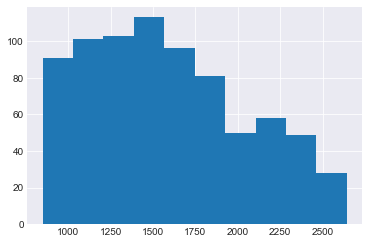

In [632]:
plt.hist(predicted_prices_no_ouliers_std_1);

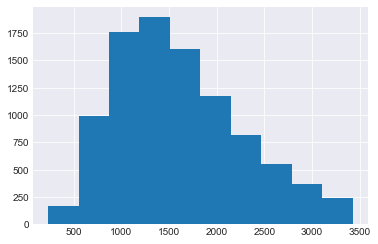

In [633]:
plt.hist(predicted_prices_no_outliers_std_2);

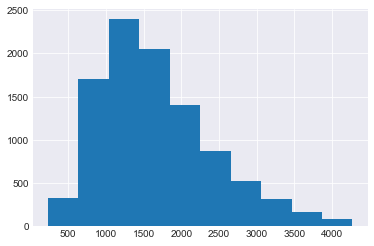

In [634]:
plt.hist(predicted_prices_no_outliers_std_3);